#### Generating shuffled datasets

This will generate coherences that are shifted relative to each other in time and then plot the R^2 distributions of those relatively



In [8]:
%matplotlib inline
import sys
import itertools
from repoze.lru import lru_cache

# Check the system type
if sys.platform == 'darwin':
    sys.path.append('/users/fluongo/documents/Python_stuff/subnets-ecog')
elif sys.platform == 'linux2':
    sys.path.append('/home/fluongo/python_modules/subnets-ecog')
    compSpec = '/Sohal'
else:
    sys.path.append('C:\\python_modules\\subnets-ecog')

import numpy as np
import matplotlib.pyplot as plt
import ecogRecordingParams as recParams
import ecogMiscellaneous as ecogMisc
import ecogVisualizations as ecogVis
import ecogAnalysis

from ecogMiscellaneous import get_PC_loading_sums, compute_R_v_loading, compute_projections, shuffle_coherences

import os
import networkx as nx
import datetime

import seaborn as sns
from pandas import DataFrame
import scipy.stats as stats

sns.set_style("white")
sns.set_style("ticks")

In [72]:

def shuffle_coherences(coh_data, totalShuffle = False, nShuffleRepeats = 5):
    ''' Shuffles coherences by shifting each train in time by a random number T relative to each other
    
    Arguments:
    
    coh_data -- Coherence data
    
    Output:
    
    coh_shuffled -- Shuffled version of the coherences
    '''
    
    coh_data = np.nan_to_num(coh_data)
    
    nR = coh_data.shape[0] # Number of regions
    nT = coh_data.shape[2] # Number of timepoints
    coh_shuffled = np.zeros_like(coh_data)
    
    if totalShuffle == False:
        rand_shift = np.random.randint(0, nT, size = (nR**2 + nR)/2)

        nn = 0
        for i in range(nR):
            for j in range(i, nR):
                # First shuffle
                shuffled_coh = np.hstack([coh_data[i,j,rand_shift[nn]:], coh_data[i,j,:rand_shift[nn]]])
                nn+=1
                
                # Subsequent Shuffles
                for kk in np.random.randint(0,nT, size = nShuffleRepeats):
                    shuffled_coh = np.hstack([shuffled_coh[kk:], shuffled_coh[:kk]])
                
                coh_shuffled[i,j,:] = shuffled_coh
                coh_shuffled[j,i,:] = coh_shuffled[i,j,:]
    
    if totalShuffle == True:
        for i in range(nR):
            for j in range(i, nR):
                coh_shuffled[i,j,:] = coh_data[i,j,np.random.permutation(range(nT))]
                coh_shuffled[j,i,:] = coh_shuffled[i,j,:]
    
    return coh_shuffled


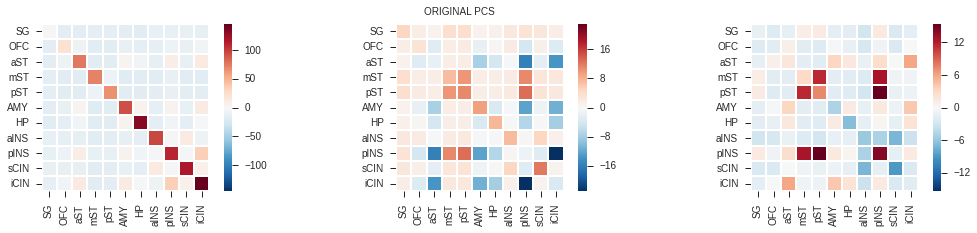

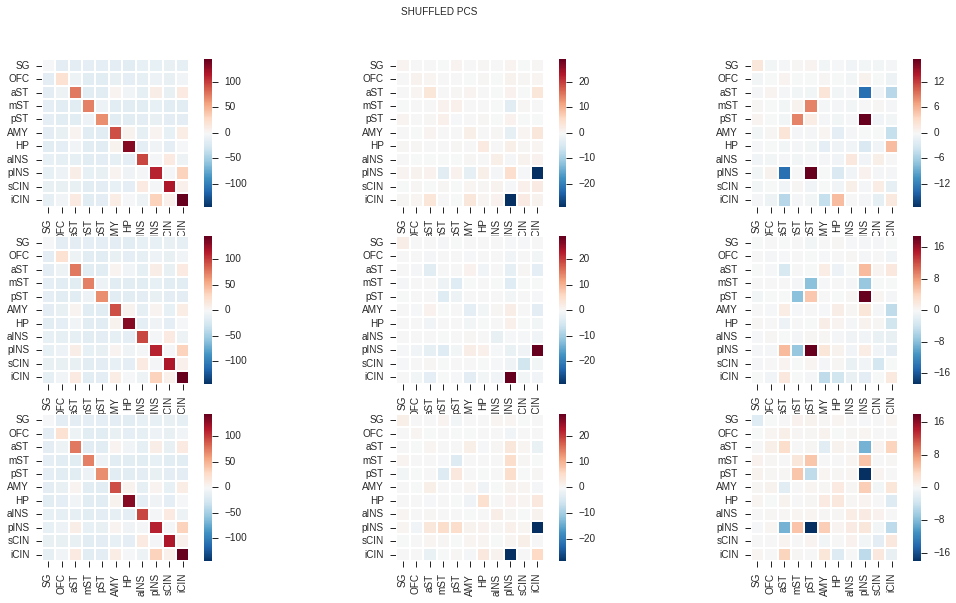

In [135]:

pc_data, coh_data, refNames = ecogMisc.load_data('EC71')

PCrank = 0
data = np.nan_to_num(coh_data['theta'])

PC, eigV = ecogAnalysis.pca_calculation(data, nPCs = 5)
plt.figure(figsize = [18, 3])
plt.subplot(1,3,1); ecogMisc.plot_im(PC[:,:,0], refNames)
plt.subplot(1,3,2); ecogMisc.plot_im(PC[:,:,1], refNames)
plt.subplot(1,3,3); ecogMisc.plot_im(PC[:,:,2], refNames); plt.suptitle('ORIGINAL PCS')

plt.figure(figsize = [18, 9])
for kk in range(3):
    coh_shuff = shuffle_coherences(data, totalShuffle = False, nShuffleRepeats = 50)
    PC, eigV = ecogAnalysis.pca_calculation(coh_shuff, nPCs = 5)
    plt.subplot(3,3,3*kk+1)
    ecogMisc.plot_im(PC[:,:,0], refNames)
    plt.subplot(3,3,3*kk+2)
    ecogMisc.plot_im(PC[:,:,1], refNames)
    plt.subplot(3,3,3*kk+3)
    ecogMisc.plot_im(PC[:,:,2], refNames)
    
plt.suptitle('SHUFFLED (50 cuts) PCS')

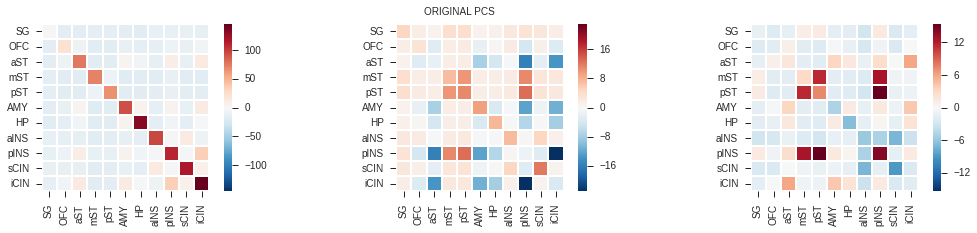

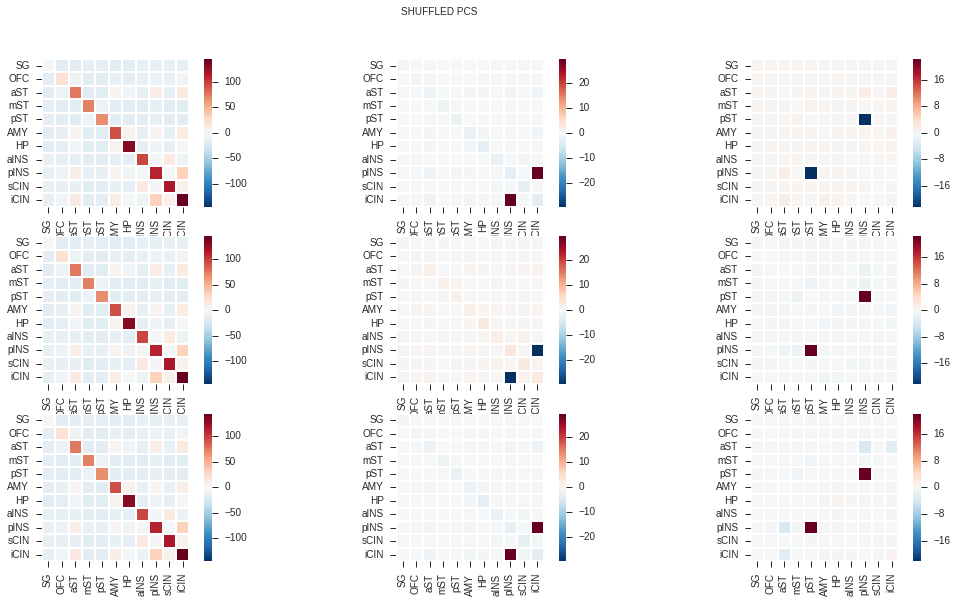

In [136]:
pc_data, coh_data, refNames = ecogMisc.load_data('EC71')

PCrank = 0
data = np.nan_to_num(coh_data['theta'])

PC, eigV = ecogAnalysis.pca_calculation(data, nPCs = 5)
plt.figure(figsize = [18, 3])
plt.subplot(1,3,1); ecogMisc.plot_im(PC[:,:,0], refNames)
plt.subplot(1,3,2); ecogMisc.plot_im(PC[:,:,1], refNames)
plt.subplot(1,3,3); ecogMisc.plot_im(PC[:,:,2], refNames); plt.suptitle('ORIGINAL PCS')
 
plt.figure(figsize = [18, 9])
for kk in range(3):
    coh_shuff = shuffle_coherences(data, totalShuffle = True)
    PC, eigV = ecogAnalysis.pca_calculation(coh_shuff, nPCs = 5)
    plt.subplot(3,3,3*kk+1)
    ecogMisc.plot_im(PC[:,:,0], refNames)
    plt.subplot(3,3,3*kk+2)
    ecogMisc.plot_im(PC[:,:,1], refNames)
    plt.subplot(3,3,3*kk+3)
    ecogMisc.plot_im(PC[:,:,2], refNames)
    
plt.suptitle('SHUFFLED (total) PCS')

# Distributions of loadings in shuffled vs. Real data


Summary:
    
    Basically the first PC is just a noise PC in the sense that it is still there when the data is shuffled, but everything beyond that is real in the sense that it is not there when you shuffle the data

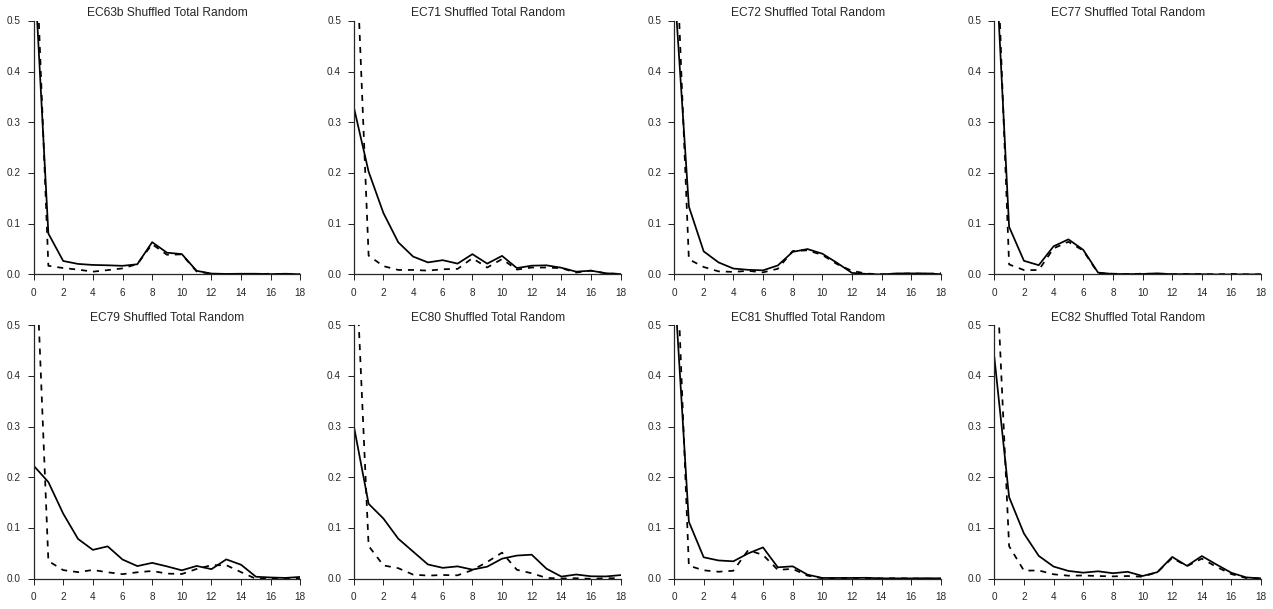

In [28]:
kk = 1 # For subplots
plt.figure(figsize = [22,10])

for patientID in ['EC63b', 'EC71', 'EC72', 'EC77', 'EC79', 'EC80', 'EC81', 'EC82']:
    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    dataS = []; data = []
    for band in ['delta', 'theta', 'beta', 'alpha', 'gamma']:
        coh_original = np.nan_to_num(coh_data[band])
        coh_shuff = shuffle_coherences(coh_original, totalShuffle = True, nShuffleRepeats = 50)
        try:
            PCs, eigV = ecogAnalysis.pca_calculation(coh_shuff, nPCs = 5)
        except:
            print 'passing ' + patientID + ' ' + band
            pass
            
        PC, eigV = ecogAnalysis.pca_calculation(coh_original, nPCs = 5)
        for PCrank in range(0,5):
            dataS.extend(PCs[:,:,PCrank].ravel())
            data.extend(PC[:,:,PCrank].ravel())

    n, bins = np.histogram(np.abs(data), bins = range(20), normed = True)
    n2, bins = np.histogram(np.abs(dataS), bins = range(20), normed = True)

    plt.subplot(2,4,kk); kk+=1
    plt.plot(bins[:-1], n, 'k'); plt.plot(bins[:-1], n2, 'k--');
    plt.ylim([0,0.5]); plt.title(patientID + ' Shuffled Total Random');sns.despine()
    

passing EC63b delta
passing EC81 delta


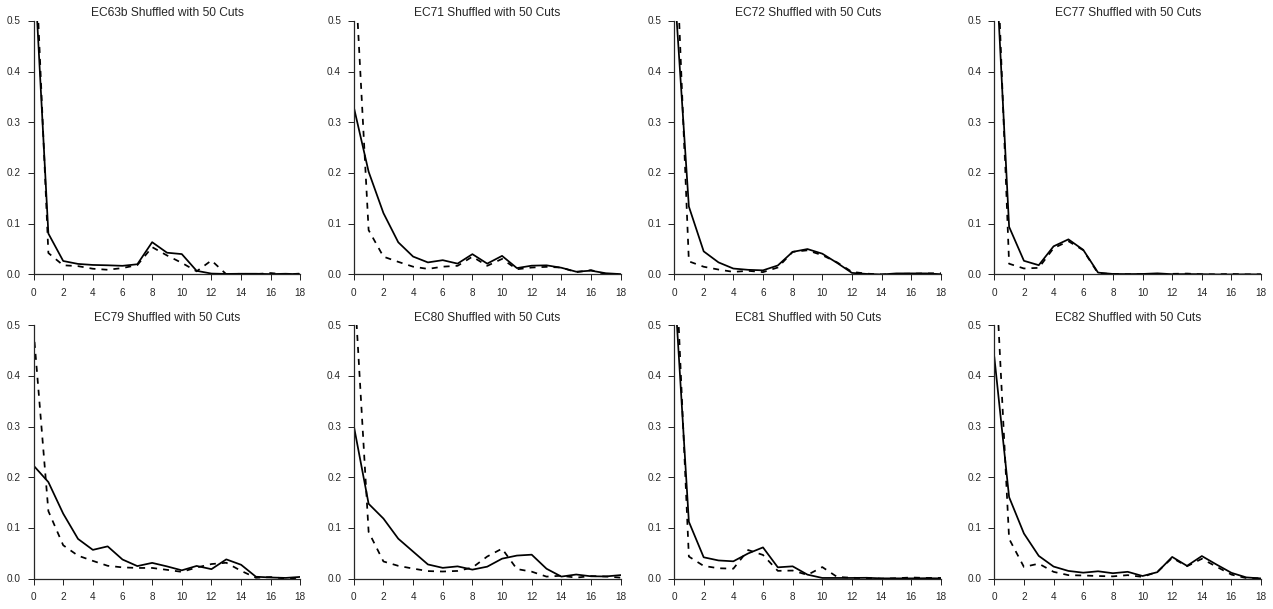

In [27]:
kk = 1 # For subplots
plt.figure(figsize = [22,10])

for patientID in ['EC63b', 'EC71', 'EC72', 'EC77', 'EC79', 'EC80', 'EC81', 'EC82']:
    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    dataS = []; data = []
    for band in ['delta', 'theta', 'beta', 'alpha', 'gamma']:
        coh_original = np.nan_to_num(coh_data[band])
        coh_shuff = shuffle_coherences(coh_original, totalShuffle = False, nShuffleRepeats = 50)
        try:
            PCs, eigV = ecogAnalysis.pca_calculation(coh_shuff, nPCs = 5)
        except:
            print 'passing ' + patientID + ' ' + band
            pass
        
        PC, eigV = ecogAnalysis.pca_calculation(coh_original, nPCs = 5)
        for PCrank in range(0,5):
            dataS.extend(PCs[:,:,PCrank].ravel())
            data.extend(PC[:,:,PCrank].ravel())

    n, bins = np.histogram(np.abs(data), bins = range(20), normed = True)
    n2, bins = np.histogram(np.abs(dataS), bins = range(20), normed = True)

    plt.subplot(2,4,kk); kk+=1
    plt.plot(bins[:-1], n, 'k'); plt.plot(bins[:-1], n2, 'k--');
    plt.ylim([0,0.5]); plt.title(patientID + ' Shuffled with 50 Cuts'); sns.despine()
    

## Check for power law distributions of R**2 values.....

Do this only for PCs 2-5 since number 1 should be ignored

In [16]:
def compute_R_plaw(PC, coh_data):
    ''' Computes the power law R**2 distribution 
    '''
    projections  = compute_projections(PC, coh_data)
    nR = coh_data.shape[0]
    
    # Generate the R value ditribution of each coherence to each projection
    Rs = []
    for i in range(nR):
        for j in range(i,nR):
            for PCrank in range(projections.shape[0]):
                Rs.append(ecogMisc.rsquared(coh_data[i,j,:], projections[PCrank]))
    return Rs

passing EC79 alpha


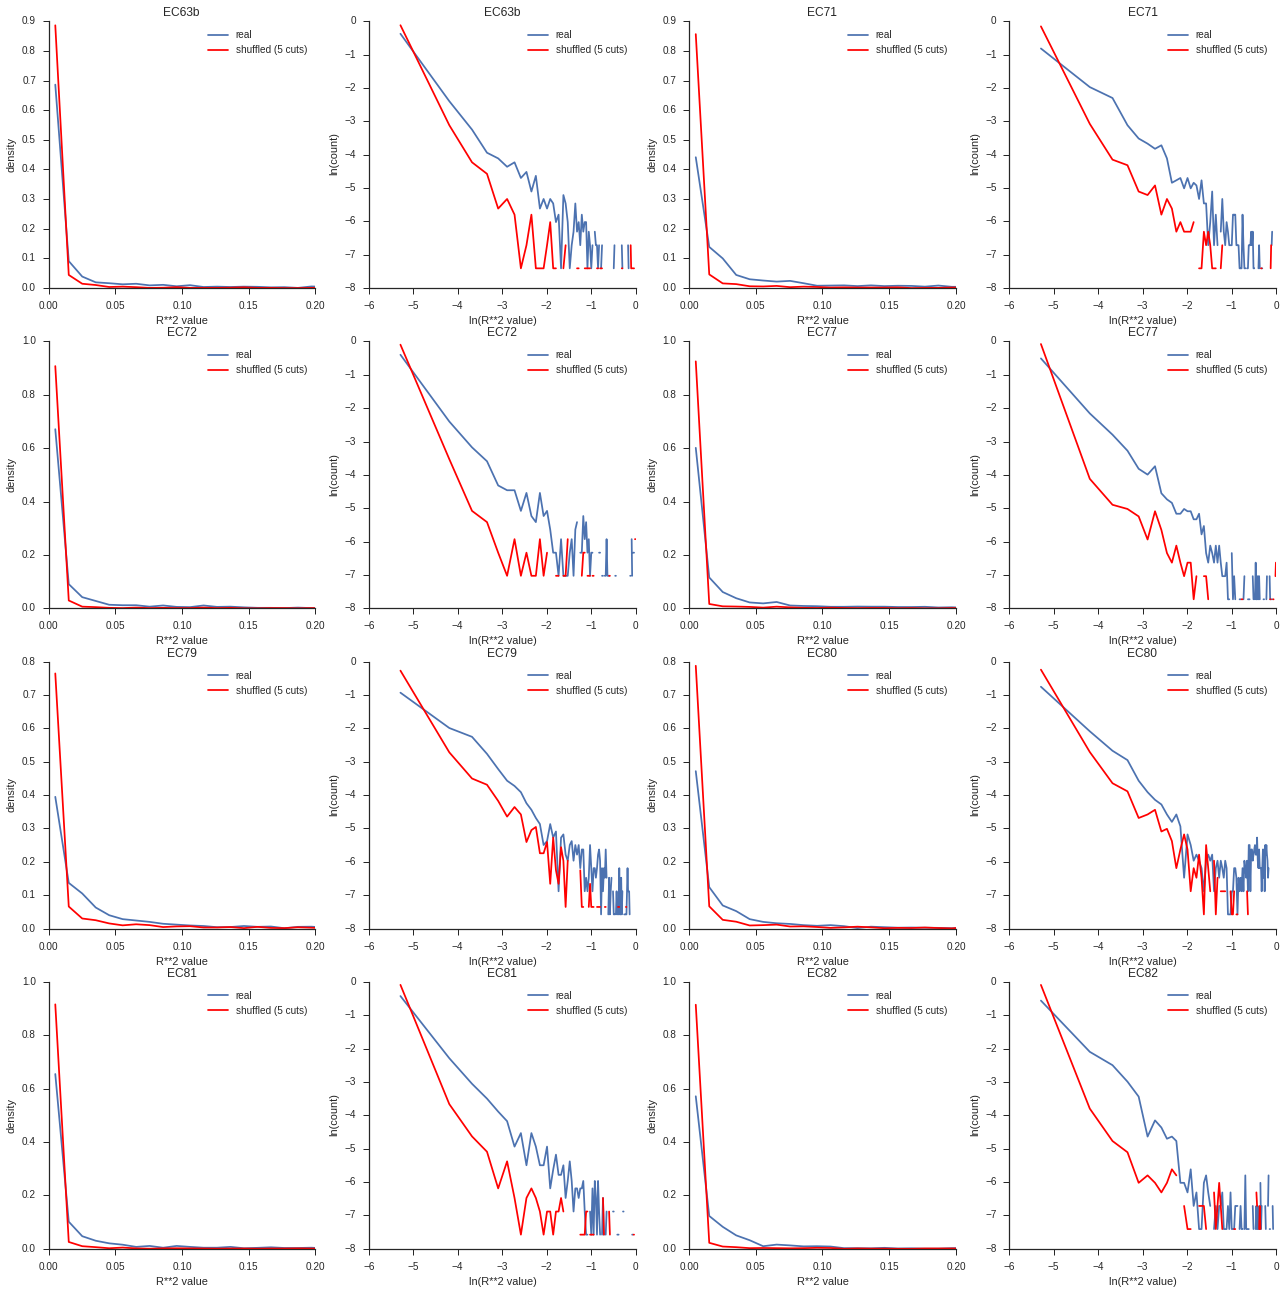

In [23]:
from ecogMiscellaneous import get_PC_loading_sums, compute_R_v_loading, compute_projections

kk = 1 # For subplots
plt.figure(figsize = [22,22])

for patientID in ['EC63b', 'EC71', 'EC72','EC77', 'EC79', 'EC80', 'EC81', 'EC82']:
    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    
    Rs = []; Rs_shuff = []
    for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
        cohs = np.nan_to_num(coh_data[band])
        PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
        coh_shuff = shuffle_coherences(cohs, totalShuffle = False, nShuffleRepeats = 5)
        
        # Try it twice in case it doesnt converge once
        try:
            PC_shuff, eigV = ecogAnalysis.pca_calculation(coh_shuff, nPCs = 5)
            Rs_shuff.extend(compute_R_plaw(PC_shuff, coh_shuff))
        except:
            print 'passing ' + patientID + ' ' + band
            pass
        
        Rs.extend(compute_R_plaw(PC, cohs))

    n, bins  = np.histogram(Rs, bins = np.linspace(0,1,100), density = True)
    n2, bins  = np.histogram(Rs_shuff, bins = np.linspace(0,1,100), density = True)
    
    # Normalize to 1
    n = n/np.sum(n); n2 = n2/np.sum(n2)
    # Take bin means
    bin_means = (bins[:-1]+bins[1:])/2
    
    # PLOTS
    plt.subplot(4,4,kk); kk+=1
    plt.plot(bin_means, n, label = 'real')
    plt.plot(bin_means, n2, 'r', label = 'shuffled (5 cuts)'); plt.xlim([0, 0.2])
    plt.xlabel('R**2 value'); plt.ylabel('density')
    plt.legend(); plt.title(patientID); sns.despine()
    
    plt.subplot(4,4,kk); kk+=1
    plt.plot(np.log(bin_means), np.log(n), label = 'real')
    plt.plot(np.log(bin_means), np.log(n2), 'r', label = 'shuffled (5 cuts)'); 
    plt.xlabel('ln(R**2 value)')
    plt.ylabel('ln(count)')
    plt.legend(); plt.title(patientID); sns.despine()
    

passing EC63b delta
passing EC77 alpha


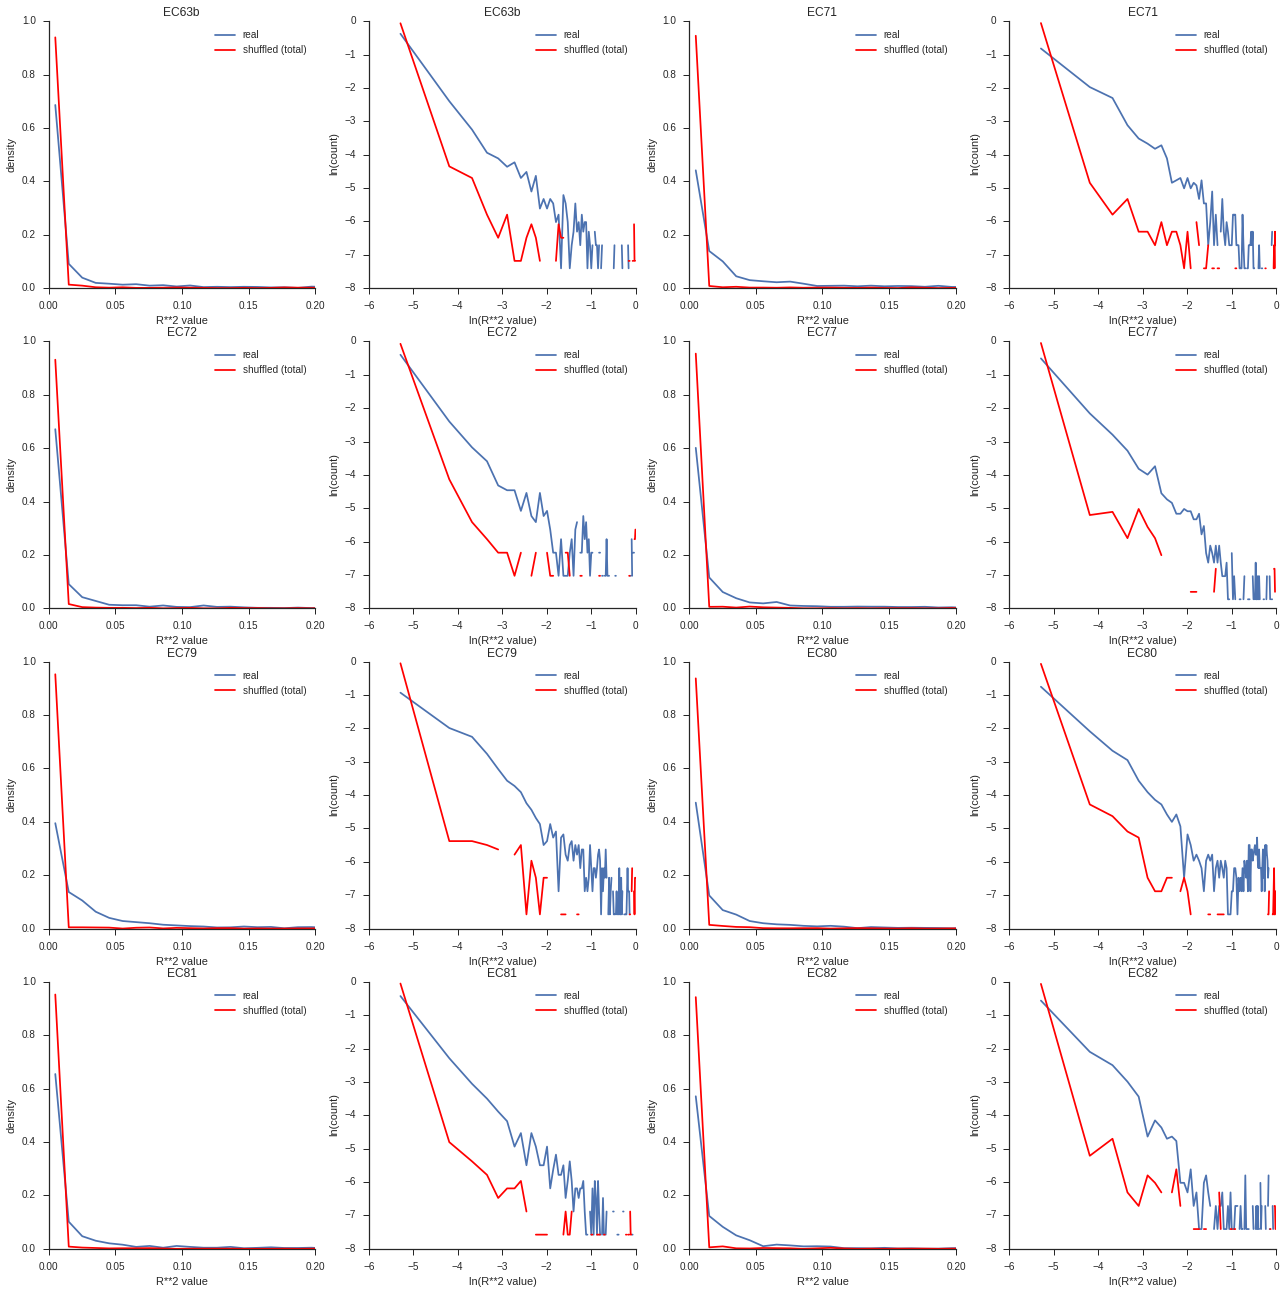

In [24]:
from ecogMiscellaneous import get_PC_loading_sums, compute_R_v_loading, compute_projections

kk = 1 # For subplots
plt.figure(figsize = [22,22])

for patientID in ['EC63b', 'EC71', 'EC72','EC77', 'EC79', 'EC80', 'EC81', 'EC82']:
    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    
    Rs = []; Rs_shuff = []
    for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
        cohs = np.nan_to_num(coh_data[band])
        PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)

        coh_shuff = shuffle_coherences(cohs, totalShuffle = True)
        
        # Try it twice in case it doesnt converge once
        try:
            PC_shuff, eigV = ecogAnalysis.pca_calculation(coh_shuff, nPCs = 5)
            Rs_shuff.extend(compute_R_plaw(PC_shuff, coh_shuff))
        except:
            print 'passing ' + patientID + ' ' + band
            pass
        
        Rs.extend(compute_R_plaw(PC, cohs))
        
    n, bins  = np.histogram(Rs, bins = np.linspace(0,1,100), density = True)
    n2, bins  = np.histogram(Rs_shuff, bins = np.linspace(0,1,100), density = True)
    
    # Normalize to 1
    n = n/np.sum(n); n2 = n2/np.sum(n2)
    # Take bin means
    bin_means = (bins[:-1]+bins[1:])/2
    
    # PLOTS
    plt.subplot(4,4,kk); kk+=1
    plt.plot(bin_means, n, label = 'real')
    plt.plot(bin_means, n2, 'r', label = 'shuffled (total)'); plt.xlim([0, 0.2])
    plt.xlabel('R**2 value'); plt.ylabel('density')
    plt.legend(); plt.title(patientID); sns.despine()
    
    plt.subplot(4,4,kk); kk+=1
    plt.plot(np.log(bin_means), np.log(n), label = 'real')
    plt.plot(np.log(bin_means), np.log(n2), 'r', label = 'shuffled (total)'); 
    plt.xlabel('ln(R**2 value)')
    plt.ylabel('ln(count)')
    plt.legend(); plt.title(patientID); sns.despine()

## Loadings percentage vs. R**2 value.....

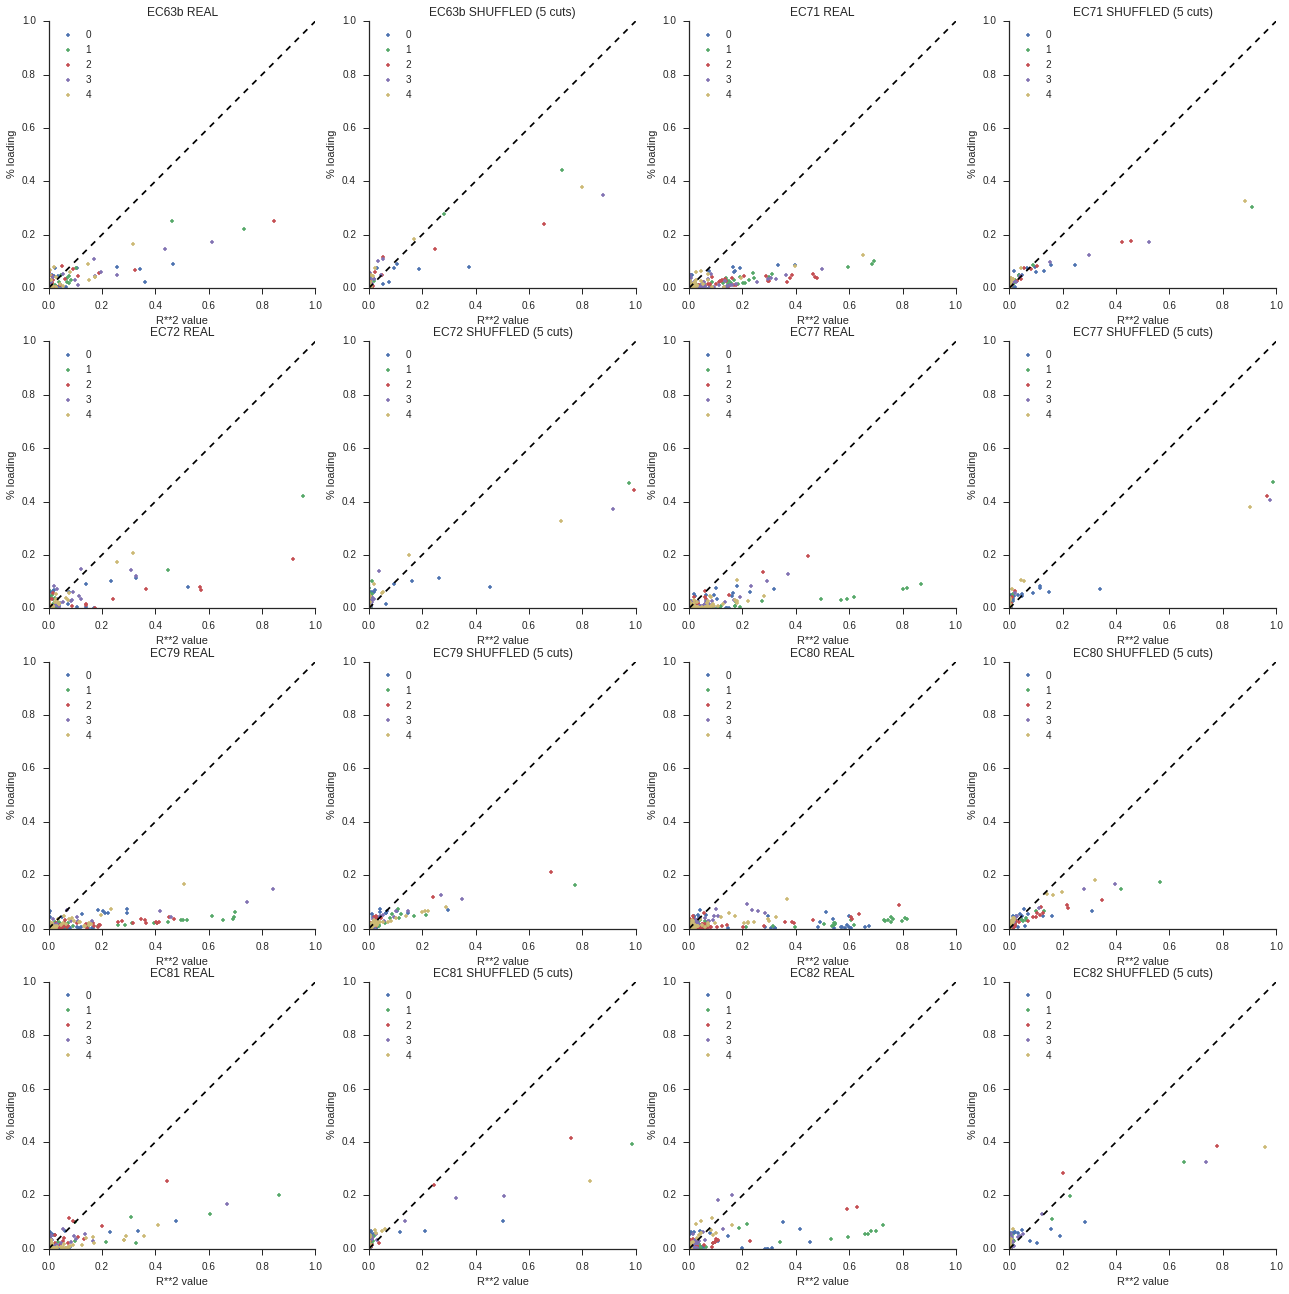

In [206]:
from ecogMiscellaneous import get_PC_loading_sums, compute_R_v_loading, compute_projections

band = 'alpha'    
plt.figure(figsize = [22,22]); kk = 1 # Setting up figure and subplot index

for patientID in ['EC63b', 'EC71', 'EC72','EC77', 'EC79', 'EC80', 'EC81', 'EC82']:

    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    
    # Real version
    cohs = np.nan_to_num(coh_data[band])
    PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PC, cohs); sns.despine(); plt.title(patientID + ' REAL')
    
    # Shuffled version
    cohs_shuff = shuffle_coherences(cohs, totalShuffle = False, nShuffleRepeats = 5)
    PCshuff, eigV = ecogAnalysis.pca_calculation(cohs_shuff, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PCshuff, cohs_shuff); sns.despine(); plt.title(patientID + ' SHUFFLED (5 cuts)')

### Leave one out analysis....


In this analysis we will calculate the R**2 value for a given 

1. Calculate the Projection while leaving out just that interaction
2. Compute the R**2 value with that projection where you left it out
3. Plot it same as above with R**2 on X and % loading on Y


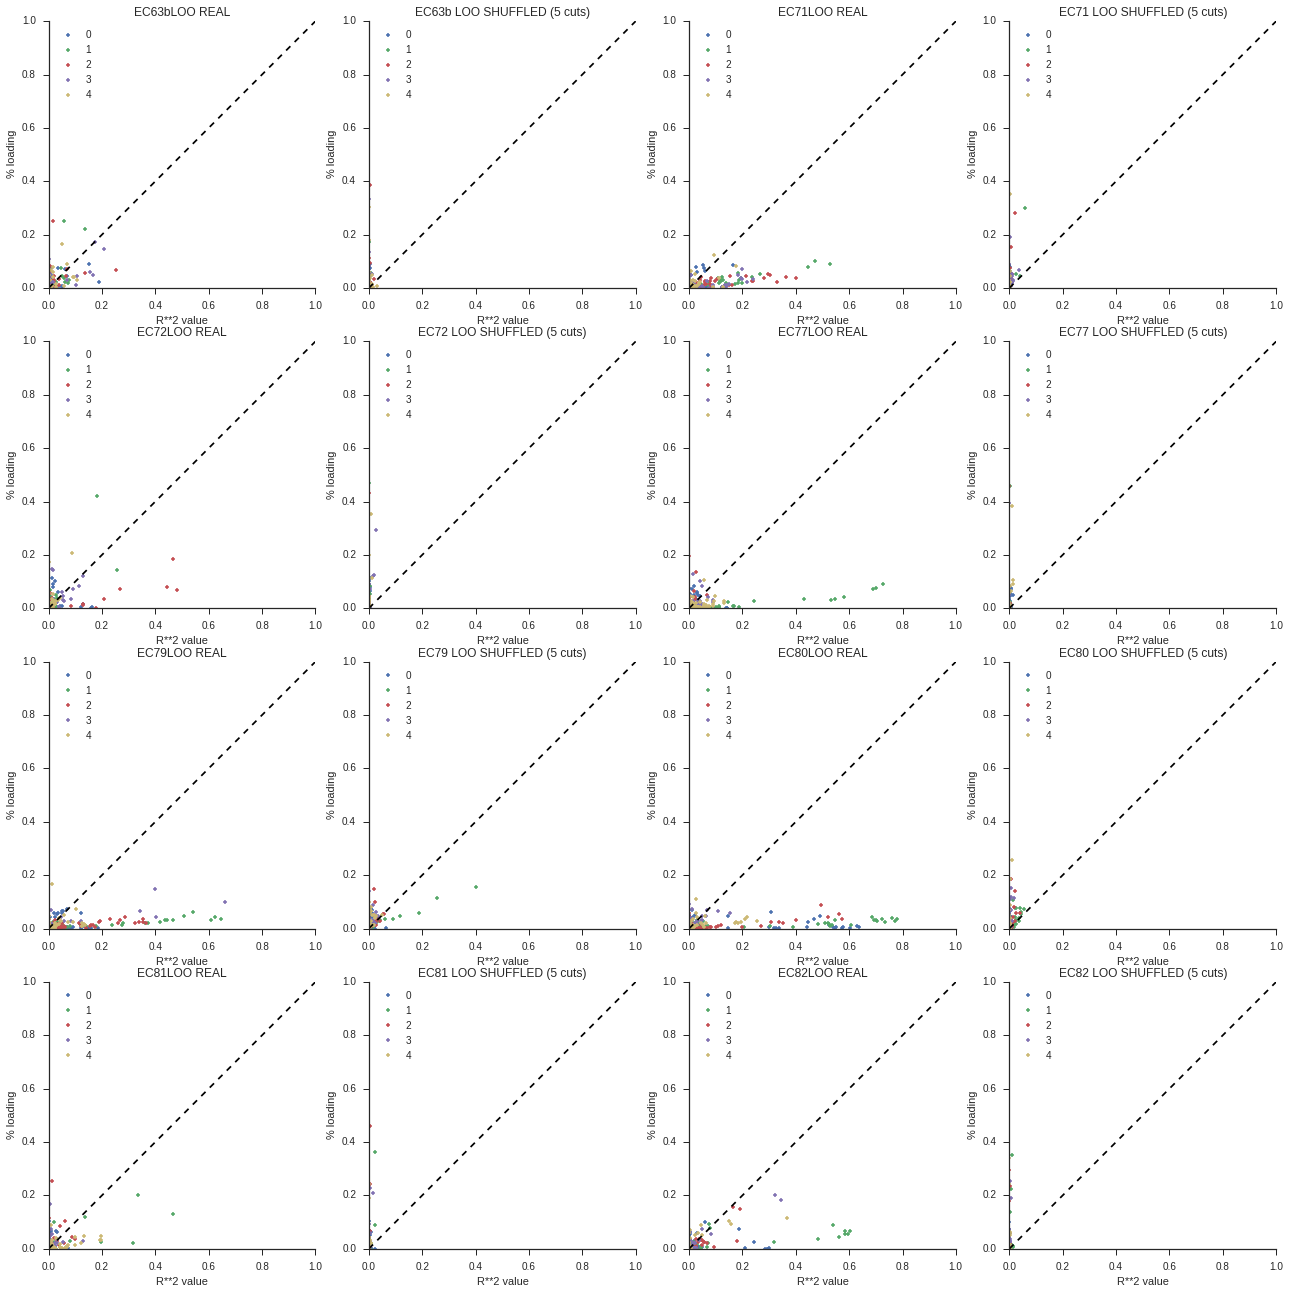

In [220]:
reload(ecogMisc)
from ecogMiscellaneous import get_PC_loading_sums, compute_R_v_loading, compute_projections

#############
#CODE

band = 'alpha'    
plt.figure(figsize = [22,22]); kk = 1 # Setting up figure and subplot index

for patientID in ['EC63b', 'EC71', 'EC72','EC77', 'EC79', 'EC80', 'EC81', 'EC82']:

    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    
    # Real version
    cohs = np.nan_to_num(coh_data[band])
    PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PC, cohs, leaveOneOut = True); sns.despine(); plt.title(patientID + ' LOO REAL')
    
    # Shuffled version
    cohs_shuff = shuffle_coherences(cohs, totalShuffle = False, nShuffleRepeats = 5)
    PCshuff, eigV = ecogAnalysis.pca_calculation(cohs_shuff, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PCshuff, cohs_shuff, leaveOneOut = True); sns.despine(); 
    plt.title(patientID + ' LOO SHUFFLED (5 cuts)')

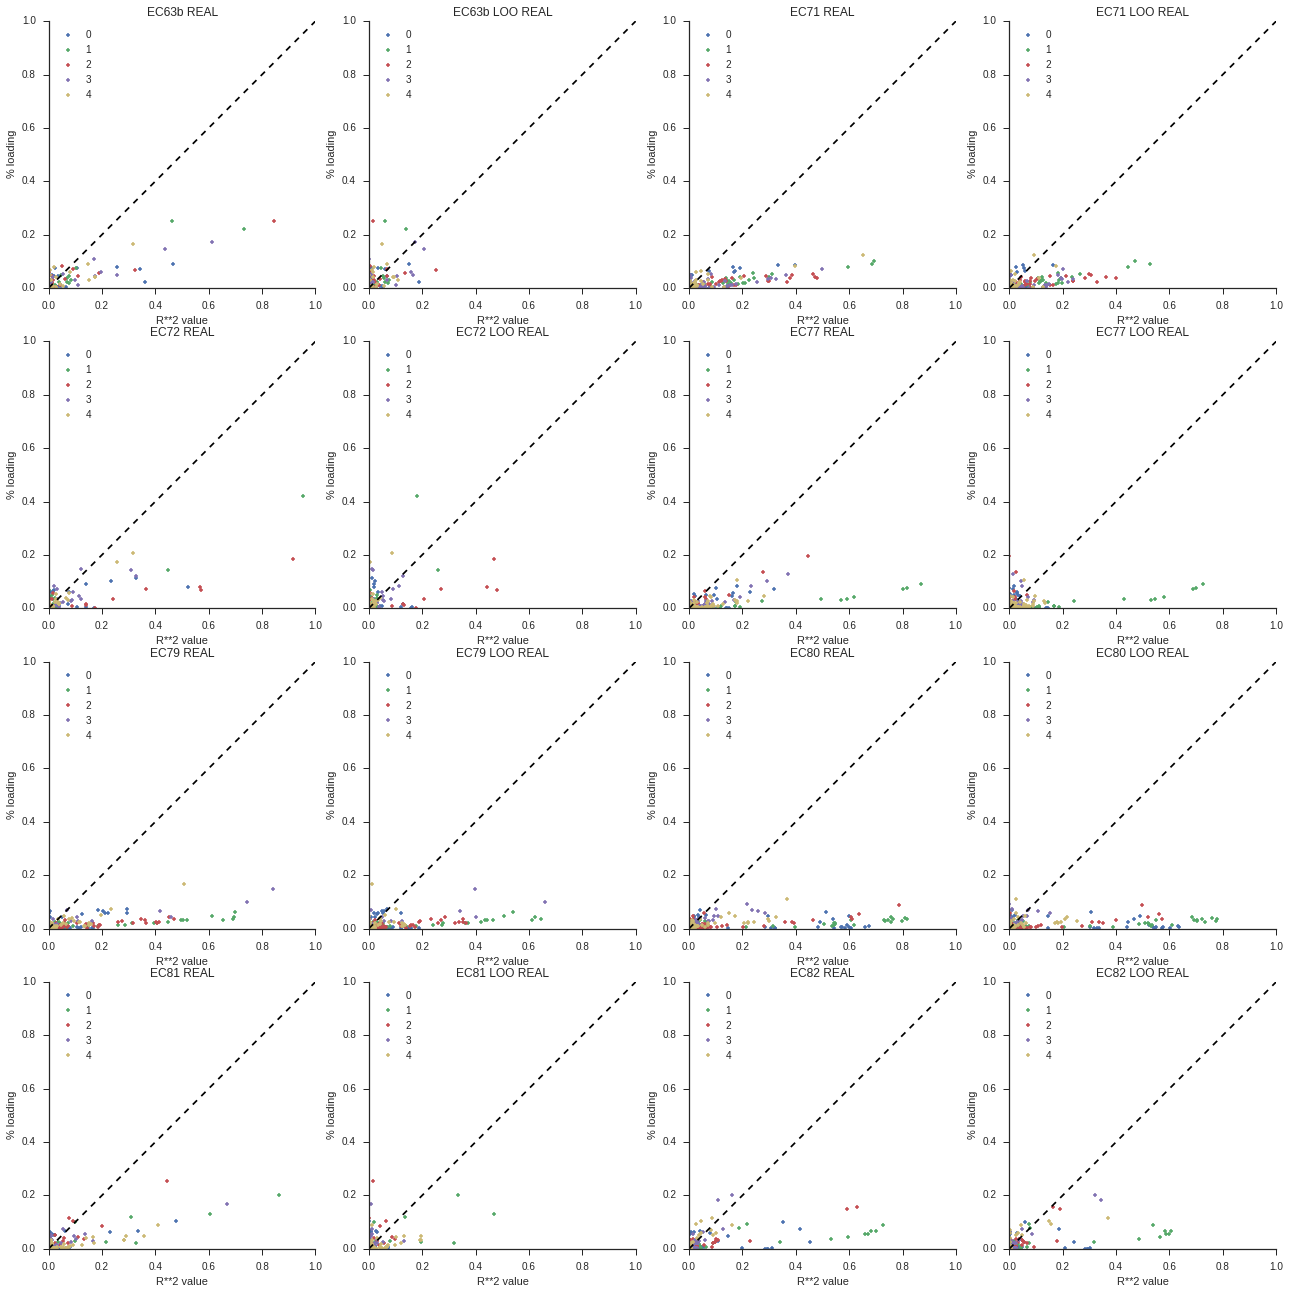

In [229]:
from ecogMiscellaneous import get_PC_loading_sums, compute_R_v_loading, compute_projections

#############
#CODE

band = 'alpha'    
plt.figure(figsize = [22,22]); kk = 1 # Setting up figure and subplot index

for patientID in ['EC63b', 'EC71', 'EC72','EC77', 'EC79', 'EC80', 'EC81', 'EC82']:

    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    
    # Real version no LOO
    cohs = np.nan_to_num(coh_data[band])
    PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PC, cohs, leaveOneOut = False); sns.despine(); plt.title(patientID + ' REAL')
    
    # Real version LOO
    cohs = np.nan_to_num(coh_data[band])
    PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PC, cohs, leaveOneOut = True); sns.despine(); plt.title(patientID + ' LOO REAL')

### Leave One Out/ Shuffled with 1 Cut is sufficient to abolish basically all R**2 predictability

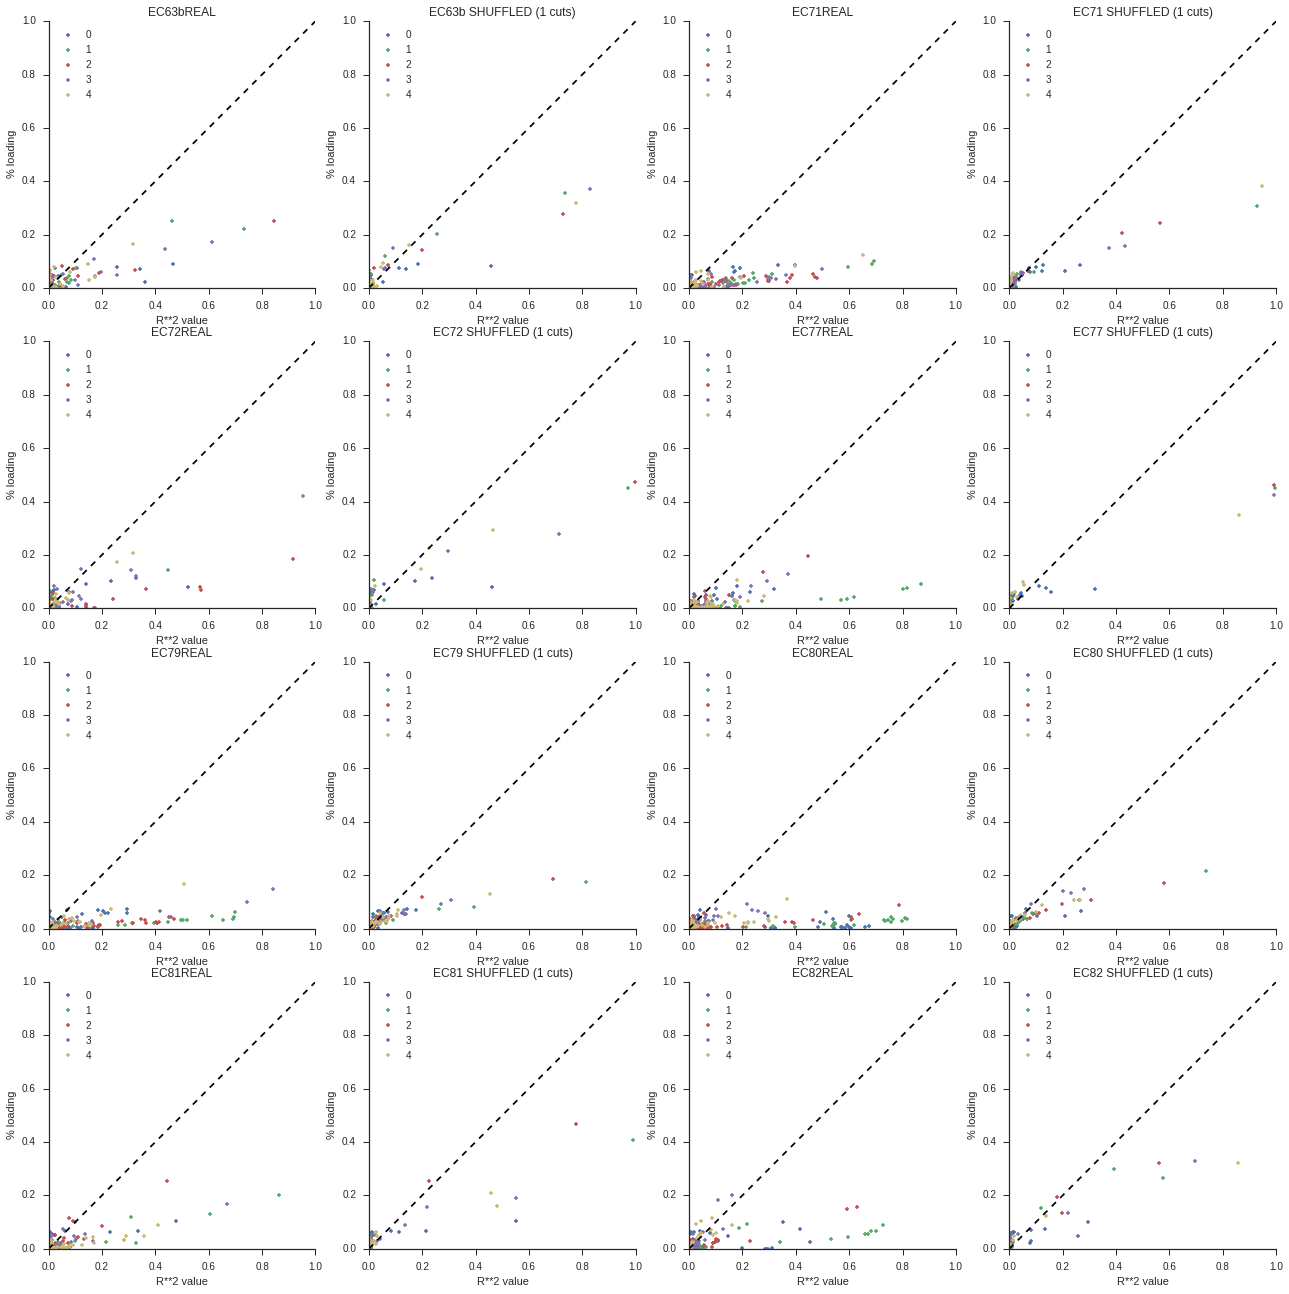

In [235]:
#############
#CODE

band = 'alpha'    
plt.figure(figsize = [22,22]); kk = 1 # Setting up figure and subplot index

for patientID in ['EC63b', 'EC71', 'EC72','EC77', 'EC79', 'EC80', 'EC81', 'EC82']:

    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    
    # Real version
    cohs = np.nan_to_num(coh_data[band])
    PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PC, cohs, leaveOneOut = False); sns.despine(); plt.title(patientID + 'REAL')
    
    # Shuffled version
    cohs_shuff = shuffle_coherences(cohs, totalShuffle = False, nShuffleRepeats = 1)
    PCshuff, eigV = ecogAnalysis.pca_calculation(cohs_shuff, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PCshuff, cohs_shuff, leaveOneOut = False); sns.despine(); 
    plt.title(patientID + ' SHUFFLED (1 cuts)')

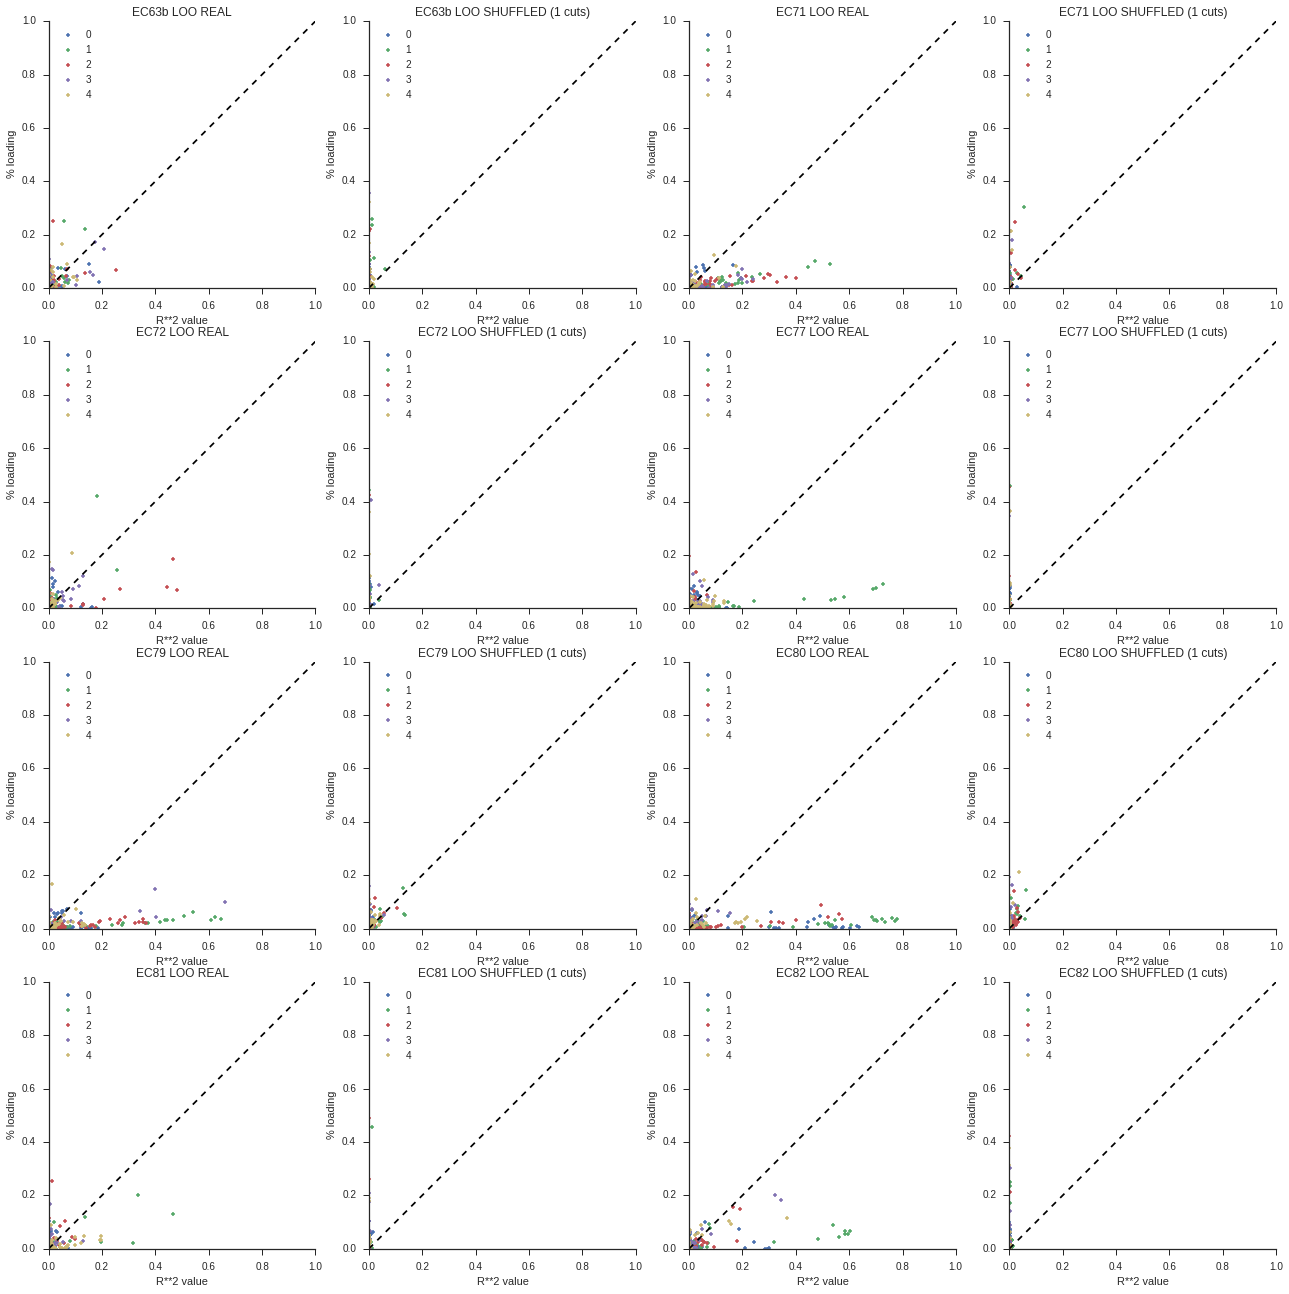

In [234]:
#############
#CODE

band = 'alpha'    
plt.figure(figsize = [22,22]); kk = 1 # Setting up figure and subplot index

for patientID in ['EC63b', 'EC71', 'EC72','EC77', 'EC79', 'EC80', 'EC81', 'EC82']:

    pc_data, coh_data, refNames = ecogMisc.load_data(patientID)
    
    # Real version
    cohs = np.nan_to_num(coh_data[band])
    PC, eigV = ecogAnalysis.pca_calculation(cohs, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PC, cohs, leaveOneOut = True); sns.despine(); plt.title(patientID + ' LOO REAL')
    
    # Shuffled version
    cohs_shuff = shuffle_coherences(cohs, totalShuffle = False, nShuffleRepeats = 1)
    PCshuff, eigV = ecogAnalysis.pca_calculation(cohs_shuff, nPCs = 5)
    plt.subplot(4,4,kk); kk+=1
    compute_R_v_loading(PCshuff, cohs_shuff, leaveOneOut = True); sns.despine(); 
    plt.title(patientID + ' LOO SHUFFLED (1 cuts)')